In [1]:
%matplotlib inline


from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score, KFold

from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [88]:
df = pd.read_csv('bank-additional-full.csv')
df.head(5)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


In [89]:
#Output value must be numerical, so I replaced categorical 'yes'/'no' with 1/0
df.replace(['yes','no', 'unknown'],[1,0, np.nan], inplace=True)
df = df.dropna()

In [90]:
def ed_preproc(ed):
    ed_new = []
    for e in ed:
        if e == 'basic.4y' or e == 'basic.6y' or e == 'basic.9y' or e == 'illiterate' or e == 'high.school':
            e = 'some'
            ed_new.append(e)
        else:
            ed_new.append(e)
    return ed_new
df.education = ed_preproc(df.education)

In [91]:
def job_proc(job):
    job_new = []
    for j in job:
        if j == 'entrepreneur':
            j = 'self-employed'
            job_new.append(j)
        elif j == 'admin.' or j == 'services' or j == 'technician':
            j = 'professional'
            job_new.append(j)
        elif j == 'housemaid':
            j = 'unemployed'
            job_new.append(j)
        else:
            job_new.append(j)
    return job_new
df.job = job_proc(df.job)

In [92]:
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,unemployed,married,some,0,0,0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0
2,37,professional,married,some,0,1,0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0
3,40,professional,married,some,0,0,0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0


In [93]:
#convert categorical data to numeric dummy variables
#Important note: this attribute highly affects the output target (e.g., if duration=0 
#then y='no'). Yet, the duration is not known before a call is performed. 
df = pd.get_dummies(df)
df['output'] = df.y
del df['duration']
del df['y']

In [94]:
df.head(3)


,age,default,housing,loan,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,output
0,56,0,0,0,1,999,0,1.1,93.994,-36.4,...,0,0,1,0,0,0,0,1,0,0
2,37,0,1,0,1,999,0,1.1,93.994,-36.4,...,0,0,1,0,0,0,0,1,0,0
3,40,0,0,0,1,999,0,1.1,93.994,-36.4,...,0,0,1,0,0,0,0,1,0,0


In [29]:
def to_df(x):
    x = pd.DataFrame(x)
    return x

In [102]:
X = df.iloc[:,:45]
#std_scale1= preprocessing.StandardScaler().fit(X)
#X = std_scale1.transform(X)
X_values_scaled = preprocessing.scale(X.astype(float), copy=False)
y = df.iloc[:,45]
x_train, x_test, y_train, y_test  = train_test_split(X, y, test_size = 0.25, random_state = 42)

# std_scale = preprocessing.StandardScaler().fit(x_train)
# x_train_std = std_scale.transform(x_train)
# x_test_std = std_scale.transform(x_test)


print "training set size: " + str(len(x_train_std))
print "test set size: " + str(len(x_test_std))
print "training_t set size: " + str(len(y_train))
print "test_t set size: " + str(len(y_test))

training set size: 22866
test set size: 7622
training_t set size: 22866
test_t set size: 7622


(1/20) Building logres model for C value 0.000000000100000 ... applying it ... done
(2/20) Building logres model for C value 0.000000001000000 ... applying it ... done
(3/20) Building logres model for C value 0.000000010000000 ... applying it ... done
(4/20) Building logres model for C value 0.000000100000000 ... applying it ... done
(5/20) Building logres model for C value 0.000001000000000 ... applying it ... done
(6/20) Building logres model for C value 0.000010000000000 ... applying it ... done
(7/20) Building logres model for C value 0.000100000000000 ... applying it ... done
(8/20) Building logres model for C value 0.001000000000000 ... applying it ... done
(9/20) Building logres model for C value 0.010000000000000 ... applying it ... done
(10/20) Building logres model for C value 0.100000000000000 ... applying it ... done
(11/20) Building logres model for C value 1.000000000000000 ... applying it ... done
(12/20) Building logres model for C value 10.000000000000000 ... applying 

scoreList =  [(0.77078513033914353, 0.014927211504280037), (0.77712163851161464, 0.01553273556243993), (0.77712589324330683, 0.015522326190777659), (0.77717140346826208, 0.015526156259077488), (0.77758482738007939, 0.015508572558818245), (0.78157654139229282, 0.015187039968745986), (0.79196347285794011, 0.013394512467362747), (0.79660284037062479, 0.012008526959931253), (0.7969107272863869, 0.012226237669430717), (0.7988979171805678, 0.01177967578280327), (0.79889883161398667, 0.0114391218684071), (0.79885618553961846, 0.011336876521203456), (0.79884695884991763, 0.011332416872495268), (0.79884492716493771, 0.011332323332062945), (0.79884563460666236, 0.011332090127898336), (0.79884512388916817, 0.01133212741521308), (0.79884523985862588, 0.011332290118810635), (0.79884466071793947, 0.011333380066232652), (0.79884444049215653, 0.011332061209479053), (0.79884442878508122, 0.011332993366369856)]
best logres model has:
roc_auc score: 79.89% (+/- 1.14%)
C value:  1
log10(C) value:  0.0


done


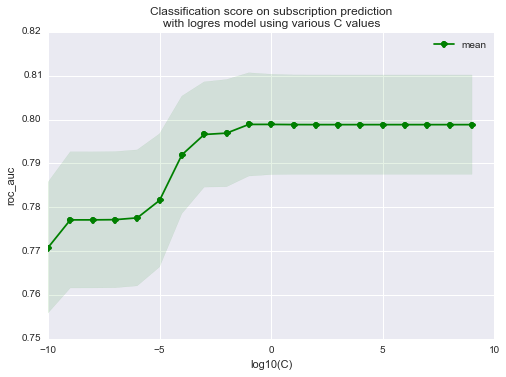

In [122]:
import sys
from math import log10
from time import sleep
kf = cross_validation.KFold(len(X_values_scaled), n_folds=10, shuffle=True)
cvGenerator = KFold(len(X_values_scaled), n_folds=10, shuffle=True)
cValues = [pow(10,(x-10)) for x in range(20)]
scorerType = 'roc_auc'
#print "cValues = ", cValues 

# selects weights inversely proportional to class frequencies in the training set
# See http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#classWeight = 'auto'
classWeight = None
bestLogCValue = None
bestKValue = None
bestNrEst = None
bestMaxFeat = None

estimators = []
scoreList = []
for i in range(len(cValues)):
    c = cValues[i]
    print >> sys.stderr, "(%d/%d) Building logres model for C value %1.15f ..." % (i+1,len(cValues),c),
    estimator = LogisticRegression(C=c,class_weight=classWeight)
    print >> sys.stderr, "applying it ...",
    scores = cross_val_score(estimator, X_values_scaled, y=y, scoring='roc_auc', cv=cvGenerator, n_jobs=1)
    estimators.append(estimator)
    scoreList.append((scores.mean(),scores.std()))
    print >> sys.stderr, "done"
# sleep(1)

print "scoreList = ", scoreList
meanScores = [x[0] for x in scoreList]

bestModelIndex = meanScores.index(max(meanScores))
print "best logres model has:"
print "%s score: %2.2f%% (+/- %2.2f%%)" % (scorerType, scoreList[bestModelIndex][0] * 100, scoreList[bestModelIndex][1] * 100)
bestCValue = cValues[bestModelIndex]
bestLogCValue = log10(bestCValue)
print "C value: ", bestCValue
print "log10(C) value: ", bestLogCValue

fig = plt.figure()
plt.plot([log10(c) for c in cValues],[x[0] for x in scoreList], 'o-', color='g', label='mean')
plt.fill_between([log10(c) for c in cValues], [x[0]-x[1] for x in scoreList],
                 [x[0]+x[1] for x in scoreList], alpha=0.1,
                 color="g", label='standard deviation')
plt.title("Classification score on subscription prediction\nwith logres model using various C values")
plt.xlabel("log10(C)")
plt.ylabel(scorerType)
plt.legend(loc='best')
plt.show()

In [32]:
X = to_df(X)
x_train = to_df(x_train)
x_test = to_df(y_train)
x_test = to_df(x_test)
x_train_std = to_df(x_train_std)
x_test_std = to_df(x_test_std)

In [33]:
type(x_train)
#x_train_std.head(5)

pandas.core.frame.DataFrame

In [50]:
#find best number for KNN
def best_neighbor(N):
    best_k = 1
    best_score = 0
    for i in range(1,N+1):
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(x_train_std, y_train)
        new_score = accuracy_score(y_test,neigh.predict(x_test_std))
        if new_score > best_score:
            best_score = new_score
            best_k = i
    
    return best_k
best_neighbor(30)

30

In [9]:
def model_search(estimator, tuned_params, scores, X_train, y_train, X_test, y_test):  
    cv = cross_validation.ShuffleSplit(len(X_train), n_iter=3, test_size=0.30, random_state=0)
    for score in scores:
        print"# Tuning hyper-parameters for %s" % score
        clf = GridSearchCV(estimator, tuned_params, cv=cv,scoring='%s' % score)
        clf.fit(X_train, y_train)
        print"Best parameters set found on development set:"
        print clf.best_params_
        print "Grid scores on development set:"
        for params, mean_score, scores in clf.grid_scores_:
            print "%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params)
        print "Detailed classification report:"
        print "The model is trained on the full development set."
        print "The scores are computed on the full evaluation set."

        y_true, y_pred = y_test, clf.predict(X_test)
        print classification_report(y_true, y_pred)


In [ ]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]
                    #{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
scores = ['precision', 'recall']
model_search(SVC(), tuned_parameters, scores, x_train_std, y_train, x_test_std, y_test)

In [10]:
tuned_parameters = [{'n_estimators': [10,20,30,40,50], 'max_features': ['auto','sqrt','log2'],
                     'criterion': ['gini', 'entropy']}]
scores = ['precision', 'recall']
model_search(RandomForestClassifier(), tuned_parameters, scores, x_train_std, y_train, x_test_std, y_test)

# Tuning hyper-parameters for precision
Best parameters set found on development set:
{'max_features': 'auto', 'n_estimators': 50, 'criterion': 'entropy'}
Grid scores on development set:
0.513 (+/-0.038) for {'max_features': 'auto', 'n_estimators': 10, 'criterion': 'gini'}
0.536 (+/-0.016) for {'max_features': 'auto', 'n_estimators': 20, 'criterion': 'gini'}
0.524 (+/-0.020) for {'max_features': 'auto', 'n_estimators': 30, 'criterion': 'gini'}
0.530 (+/-0.011) for {'max_features': 'auto', 'n_estimators': 40, 'criterion': 'gini'}
0.526 (+/-0.019) for {'max_features': 'auto', 'n_estimators': 50, 'criterion': 'gini'}
0.512 (+/-0.022) for {'max_features': 'sqrt', 'n_estimators': 10, 'criterion': 'gini'}
0.518 (+/-0.024) for {'max_features': 'sqrt', 'n_estimators': 20, 'criterion': 'gini'}
0.528 (+/-0.015) for {'max_features': 'sqrt', 'n_estimators': 30, 'criterion': 'gini'}
0.536 (+/-0.013) for {'max_features': 'sqrt', 'n_estimators': 40, 'criterion': 'gini'}
0.525 (+/-0.004) for {'max_fea

In [ ]:
tuned_parameters = [{'penalty': ['l1','l2'], 'C': [0.001,0.01,1.0,10,100,1000]}]
scores = ['precision', 'recall']
model_search(LogisticRegression(), tuned_parameters, scores, x_train_std, y_train, x_test_std, y_test)

In [ ]:
tuned_parameters = [{'criterion': ['gini', 'entropy'],'max_depth': [3,4,5,6,7], 'max_features': ['auto','log2']}]
scores = ['precision', 'recall']
model_search(DecisionTreeClassifier(), tuned_parameters, scores, x_train_std, y_train, x_test_std, y_test)

In [124]:
cValues = [pow(10,(x-10)) for x in range(20)]
for i in range(len(cValues)):
    c = cValues[i]
#     kf = cross_validation.KFold(len(x_train), n_folds=10, shuffle=True)
    kf = cross_validation.KFold(len(X_values_scaled), n_folds=10, shuffle=True)
    modelL = LogisticRegression(C=c,class_weight=None)
    pred2 = np.mean(cross_val_score(modelL, X_values_scaled, y=y, scoring='roc_auc', cv=kf, n_jobs=1))
#     scores = cross_val_score(estimator, X_values_scaled, y=y, scoring='roc_auc', cv=cvGenerator, n_jobs=1)
    print pred2

0.770428677978
0.777382525117
0.777649419969
0.777177469795
0.777576341113
0.781909794029
0.792108968945
0.796784628586
0.797876382165
0.799133358169
0.799250487985
0.799812851668
0.798789081111
0.798984982525
0.798899477084
0.799772329882
0.799368019866
0.799103999834
0.799532989303
0.799613792019


In [16]:
kf = cross_validation.KFold(len(x_train), n_folds=10, shuffle=True)
models = [LogisticRegression(C=0.1), GaussianNB(), DecisionTreeClassifier(max_features='log2',max_depth=3,criterion='entropy'), RandomForestClassifier(n_estimators=30,criterion='entropy'), KNeighborsClassifier(30)]
scores = ["accuracy", "precision", "recall", "f1", "roc_auc"]

LogisticReg = []
GaussNB = []
DecisionTree = []
RandomForest = []
kNN = []

lists = [LogisticReg, GaussNB, DecisionTree, RandomForest, kNN]

for i, model in enumerate(models):
    for score in scores:
        pred = np.mean(cross_val_score(model, X, y, scoring=score, cv=kf, n_jobs=1))
        lists[i].append(pred)

scores_df = pd.DataFrame(data = [LogisticReg, GaussNB, DecisionTree, RandomForest, kNN])
scores_df.index = ["LogisticReg", "GaussNB", "DecisionTree", "RandomForest", "kNN"]
scores_df.columns = ["Accuracy", "Precision", "Recall", "F1","ROC_AUC"]
    
print scores_df



/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              Accuracy  Precision    Recall        F1   ROC_AUC
LogisticReg   0.930381   0.554186  0.061697  0.110687  0.686328
GaussNB       0.497868   0.097753  0.716557  0.171270  0.670392
DecisionTree  0.929848   0.250000  0.008875  0.033164  0.648186
RandomForest  0.919762   0.300758  0.103206  0.159155  0.649296
kNN           0.929643   0.511803  0.060906  0.108461  0.650072


In [31]:
#Feature search: eliminate unimportant features

from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier()
X_new = clf.fit(x_train_std, y_train).transform(x_train_std)
#clf.feature_importances_  
# X_new.shape  


array([  1.08005360e-01,   2.71436035e-07,   4.10539092e-02,
         2.55037662e-02,   8.25326635e-02,   2.42040542e-02,
         1.39538946e-02,   1.38793637e-02,   2.18250232e-02,
         2.47403812e-02,   1.19544540e-01,   6.24616393e-02,
         1.50570440e-02,   9.74057174e-03,   2.56935446e-02,
         1.19037971e-02,   1.14830248e-02,   4.86565719e-03,
         8.83299623e-03,   1.33430895e-02,   1.99058928e-02,
         1.71605776e-02,   1.50152626e-02,   2.24166868e-02,
         1.68052131e-02,   1.16345858e-02,   8.72321892e-03,
         4.53934919e-03,   7.34122530e-03,   1.53226187e-03,
         7.63494301e-03,   1.10513458e-02,   1.44029803e-02,
         7.21075869e-03,   7.97850247e-03,   1.21721651e-02,
         5.11624387e-03,   1.94468193e-02,   2.44856526e-02,
         1.94440461e-02,   2.13707712e-02,   1.85521227e-02,
         9.48927309e-03,   1.44622020e-02,   4.34833079e-02])

In [113]:
print modelLR.coef_

[[  1.25416396e-03  -4.71654866e-02  -1.32957426e-02  -9.12429650e-03
   -1.16157709e-01  -2.02888328e-01  -5.43330944e-02  -2.33809768e+00
    1.21946282e+00   1.42164890e-01   2.79898290e-01   5.27886263e-01
   -3.98082820e-02  -1.07905583e-02   6.33216032e-03   4.76906364e-02
   -3.18389240e-04   4.93166528e-02  -4.66639481e-03  -1.51533453e-02
   -1.16837970e-03   1.17224604e-02  -8.36123558e-03  -3.47227623e-02
    4.27538670e-02   1.65552389e-01  -1.65552389e-01   5.01311077e-02
    2.07921331e-01   3.03321176e-02   5.72677971e-02  -1.69668660e-01
    1.97357156e-01  -1.31613310e-01  -9.54825803e-02   3.77087066e-02
    4.61676535e-02  -2.95871987e-02  -8.54032913e-02   2.77342504e-02
    1.94592918e-02   6.80280192e-02  -9.63435693e-02   3.06413400e-02
    1.01508877e-01]]


In [109]:
modelLR = LogisticRegression()
modelLR.fit(x_train_std, y_train)
y_predicted = modelLR.predict(x_test_std)
modelLR.coef_
test_features = modelLR.transform(x_train,threshold='mean')
print test_features[:5] 

[[ 0.21188711  0.72747746  0.8040951   0.78666491  0.401648   -1.42658398
   1.42658398 -0.42546303 -0.36671436 -0.12674168]
 [ 0.21188711 -1.07334749 -0.76586663 -1.15627695 -0.82112839  0.7009752
  -0.7009752  -0.42546303 -0.36671436 -0.12674168]
 [ 0.21188711 -1.07334749 -1.07678397 -1.20016617 -0.82112839  0.7009752
  -0.7009752  -0.42546303 -0.36671436 -0.12674168]
 [ 0.21188711  0.91376969  1.60872185  0.84349582  0.89528243 -1.42658398
   1.42658398 -0.42546303  2.72691802 -0.12674168]
 [ 0.21188711 -1.07334749 -0.76586663 -1.15346354 -0.82112839  0.7009752
  -0.7009752  -0.42546303 -0.36671436 -0.12674168]]


In [112]:
x_train[:5]

array([[ 0.48096537, -0.00992013, -1.08759349, -0.43055897, -0.55933525,
         0.21188711, -0.3716159 ,  0.72747746,  0.8040951 ,  0.87745109,
         0.78666491,  0.401648  , -0.47823713, -0.28638654,  0.88677582,
        -0.20381709, -0.27757536, -0.14288583, -0.22167479, -0.36319438,
         0.86195604, -0.66985458, -0.40636394,  0.96702208, -0.72015916,
        -1.42658398,  1.42658398, -0.27302509, -0.42546303, -0.07194597,
        -0.44719599, -0.36671436, -0.12674168,  1.46028629, -0.35988867,
        -0.14666431, -0.12846731, -0.48128924, -0.50928023, -0.51519879,
        -0.4926807 ,  1.99440032, -0.35785071,  0.4243334 , -0.20162497],
       [-0.2932262 , -0.00992013, -1.08759349, -0.43055897, -0.55933525,
         0.21188711, -0.3716159 , -1.07334749, -0.76586663, -1.35675611,
        -1.15627695, -0.82112839, -0.47823713, -0.28638654, -1.12768072,
        -0.20381709,  3.60262526, -0.14288583, -0.22167479, -0.36319438,
         0.86195604, -0.66985458, -0.40636394,  0.

In [115]:
df.dtypes

age                                int64
default                          float64
housing                          float64
loan                             float64
campaign                           int64
pdays                              int64
previous                           int64
emp.var.rate                     float64
cons.price.idx                   float64
cons.conf.idx                    float64
euribor3m                        float64
nr.employed                      float64
job_blue-collar                  float64
job_management                   float64
job_professional                 float64
job_retired                      float64
job_self-employed                float64
job_student                      float64
job_unemployed                   float64
marital_divorced                 float64
marital_married                  float64
marital_single                   float64
education_professional.course    float64
education_some                   float64
education_univer

In [ ]:
models = {'logistic': LogisticRegression(),
          'rf': RandomForestClassifier(n_estimators=200),
          'knn': KNeighborsClassifier(n_neighbors=30),
          'svc': SVC(probability=True),
          'tree': DecisionTreeClassifier(),
          #'gbm1': GradientBoostingClassifier(learning_rate=0.4,  n_estimators=200, subsample=1.0, random_state=1, verbose=1),
          #'gbm2': GradientBoostingClassifier(learning_rate=0.04, n_estimators=200, subsample=0.9, random_state=1, verbose=1),
         }
stage_preds = {}
final_preds = {}

In [ ]:
# for mname, m in models.iteritems():
#     print "*** %s" % mname
#     m.fit(train_std, train_t)
 
    
#     if hasattr(m, "staged_predict_proba"):
#         stage_preds[mname] = {'train': list(m.staged_predict_proba(train_std)),  'test': list(m.staged_predict_proba(test_std))}
#     #if hasattr(m, "predict_proba"):
#     final_preds[mname] = {'train': m.predict_proba(train),  'test': m.predict_proba(test)}

In [ ]:
Accuracy  Precision    Recall        F1   ROC_AUC
LogisticReg   0.887331   0.663798  0.249456  0.361990  0.800482
GaussNB       0.685855   0.256267  0.762385  0.383297  0.777621
DecisionTree  0.878598   0.647178  0.125615  0.231317  0.710939
RandomForest  0.875072   0.515097  0.309659  0.390147  0.767379
kNN           0.884051   0.628653  0.236491  0.343142  0.776927

              Accuracy  Precision    Recall        F1   ROC_AUC
LogisticReg   0.930135   0.558445  0.062503  0.111931  0.687395
GaussNB       0.503813   0.098295  0.713863  0.171992  0.670455
DecisionTree  0.929397   0.252667  0.016151  0.010862  0.650094
RandomForest  0.920746   0.315367  0.103790  0.157354  0.652943
kNN           0.929438   0.525872  0.060800  0.107888  0.654545